# Dispersed Image Trade Study

In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support, ImageNormalize, LogStretch
import ndcube
from sunpy.map import make_fitswcs_header

from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response
from mocksipipeline.detector.filter import ThinFilmFilter
from mocksipipeline.util import read_data_cube
from mocksipipeline.detector.component import DetectorComponent

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36281")
client

<Client: 'tcp://127.0.0.1:36281' processes=12 threads=96, memory=184.69 GiB>

In [2]:
spectral_cube = read_data_cube('data/moxsi-spectral-cube-ar.fits', hdu=1)

## Overlappogram Images

### Case 0

This is the nominal case.

In [3]:
al_thin = ThinFilmFilter(elements='Al', thickness=100*u.nm)

In [16]:
dc = DetectorComponent(SpectrogramChannel(1, al_thin,),)

In [8]:
dispersed_o1 = dc.compute(spectral_cube, include_gain=False)

<WCSAxesSubplot: >

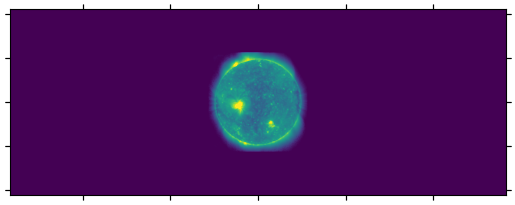

In [13]:
dispersed_o1[0].plot(
    norm=ImageNormalize(vmin=0,vmax=50,stretch=LogStretch()),
    data_unit='ph / (pix h)',
)

## Case 1

Include oxidation layer

In [8]:
al_thin_oxide = [
    ThinFilmFilter(elements='Al', thickness=93*u.nm),
    ThinFilmFilter(elements=['Al','O'], quantities=[2,3], thickness=7*u.nm),
]

### Case 2

200 nm of aluminum with oxidation layer

In [9]:
al_thick_oxide = [
    ThinFilmFilter(elements='Al', thickness=192*u.nm),
    ThinFilmFilter(elements=['Al','O'], quantities=[2,3], thickness=8*u.nm),
]

### Case 3

Al poly (100 nm of poly) with thin aluminum oxide

In [10]:
polymide = ThinFilmFilter(elements=['C','H','N','O'],
                          quantities=[22,10,2,5],
                          density=1.43*u.g/u.cm**3,
                          thickness = 100*u.nm)

In [11]:
al_poly_thin_oxide = al_thin_oxide + [polymide]

### Case 4

Al poly with thick aluminum oxide

In [12]:
al_poly_thick_oxide = al_thick_oxide + [polymide]

### Comparing Effective Areas

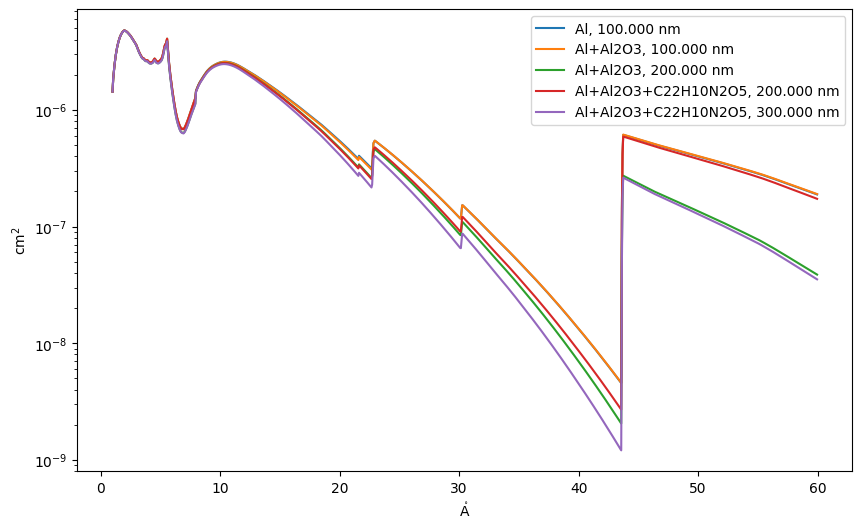

In [13]:
plt.figure(figsize=(10,6))
with quantity_support():
    for filt in [al_thin, al_thin_oxide, al_thick_oxide, al_poly_thin_oxide, al_poly_thick_oxide]:
        ch = SpectrogramChannel(0, filt)
        plt.plot(ch.wavelength, ch.effective_area, label=ch.filter_label)
plt.yscale('log')
plt.legend()

There is a layer of Au and Cr included in the calculation of the grating efficiency. What happens if that is dropped?

In [14]:
ch_no_au_cr = SpectrogramChannel(0, al_thin, include_au_cr=False)
ch_au_cr = SpectrogramChannel(0, al_thin, include_au_cr=True)

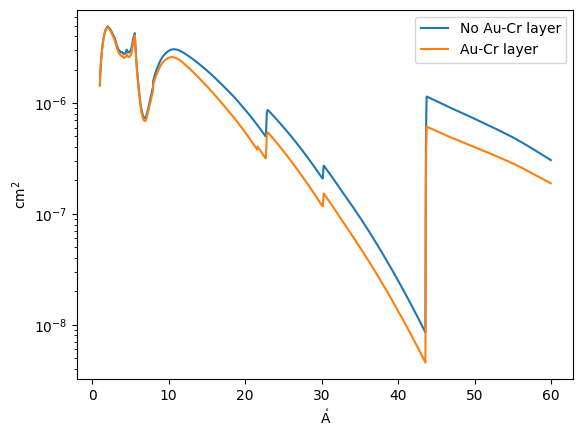

In [15]:
with quantity_support():
    plt.plot(ch_no_au_cr.wavelength, ch_no_au_cr.effective_area, label='No Au-Cr layer')
    plt.plot(ch_au_cr.wavelength, ch_au_cr.effective_area, label='Au-Cr layer')
plt.yscale('log')
plt.legend()